# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

from shapely import box
from quantum_electron.electron_counter import FullModel
from quantum_electron.schrodinger_solver import find_minimum_location, make_potential
from quantum_electron.utils import r2xy, xy2r
from zeroheliumkit.fem import FieldAnalyzer
from zeroheliumkit import Structure, Rectangle
from zeroheliumkit.src.importing import Reader_GDS
from zeroheliumkit.src.plotting import default_ax
from zeroheliumkit.src.settings import *
from zeroheliumkit.helpers.constants import *

C:\Users\eeroq2\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Device and FEM Results

./Mayer.gds // Layers in cell 'TOP': {1, 2, 7, 8, 9}


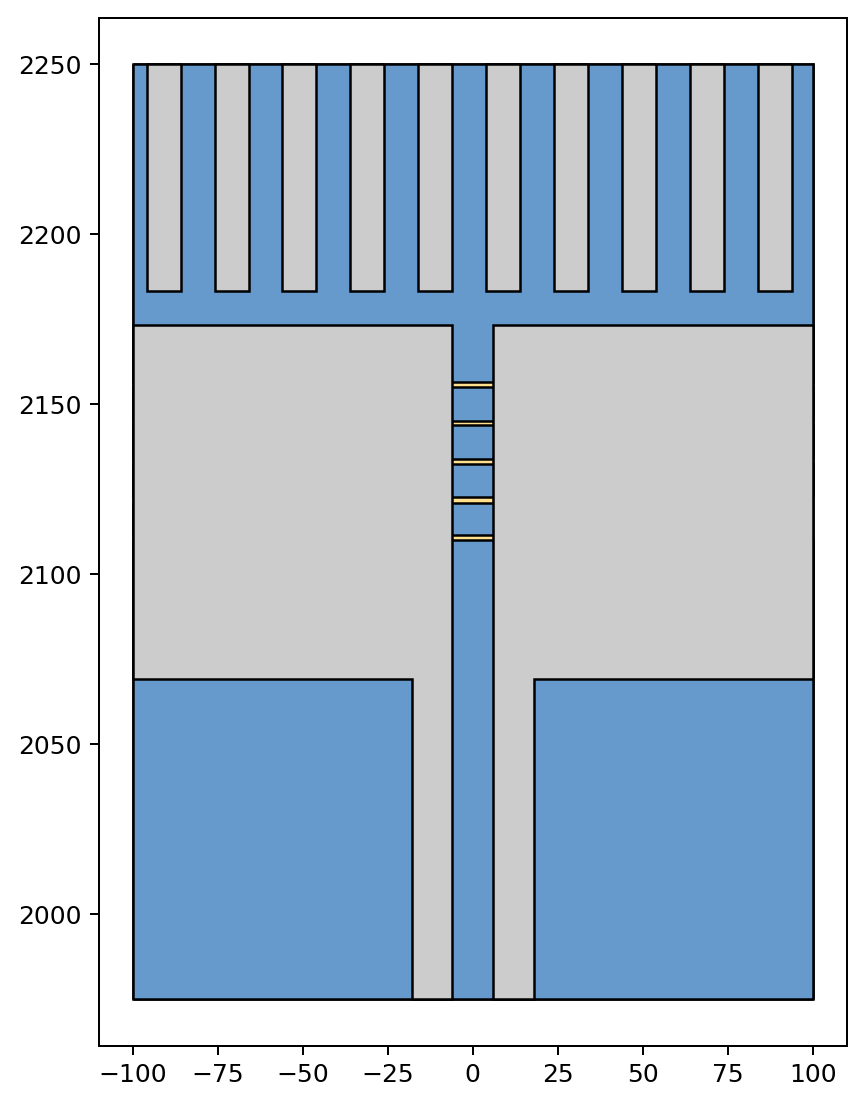

In [2]:
file = Reader_GDS('./Mayer.gds')
file.import2zhk("TOP")
device = Structure()
device.add_layer('bottom',file.geometries['L1'])
device.add_layer('top',file.geometries['L2'])
device.add_polygon('bottom',file.geometries['L8'])
device.add_layer('wafer',box(-7500,-10000,7500,10000))
device = device.crop_all(box(-100,1975,100,2250))
device.quickplot({'wafer':YELLOW2,'bottom':BLUE,'top':GRAY,'anchors':BLUE})
plt.show()

ph = FieldAnalyzer(("twiddleSense_phi_xy.txt", 'p0', '2Dmap'))
p = ph.p0

# Useful Functions 

In [86]:
#The Indicies of the central X and Y line
xCenter = int(len(p['xlist'])/2)
yCenter = int(len(p['ylist'])/2)

# Options for the Quantum electron Model
options = {"include_screening" : False, # Include screening of electron-electron interactions due to thin film.
           "screening_length" : np.inf, # Typically helium thickness.
           "potential_smoothing" : 5e-4, # Numerical smoothing of the splines (gets rid of some noise, can introduce artifacts)
           "remove_unbound_electrons" : True, # Removes electrons if they shot outside the solution box.
           "remove_bounds" : (-6, 6), # Sets which electrons should be removed if above is True.
           "trap_annealing_steps" : [0.1] * 10, # List of annealing temperatures, length determines the number of steps
           "max_x_displacement" : 0.1e-6, # Maximum x-displacement of solved electron positions during annealing.
           "max_y_displacement" : 0.1e-6} # Maximum y-displacement of solved electron positions during annealing.

#plots a potential overlayed over a drawing of the gates
def plot_gates_potential(x,y,z,title =None):
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    plt.pcolormesh(x,y,np.transpose(z),alpha=.9)
    plt.colorbar()
    device.plot(ax=ax, layer=["bottom",], color=[BLACK],show_idx=False,alpha=.1)
    device.plot(ax=ax, layer=["top",], color=[BLACK],show_idx=False,alpha=.1)
    ax.set_aspect('equal')
    plt.ylim(y[0]-10,y[-1]+10)
    plt.xlim(x[0]-30,x[-1]+30)
    if title is not None:
        plt.title(title)

### These are functions I wrote that are used for the initial electron position guess
# Makes sure the initial points aren't too close (based on the epsilon arguement) to prevent the position solver from blowing up (avoiding large electron repulsion forces).
def nonoverlap(points,point,epsilon=.01):
    trialPoints = points.copy()
    trialPoints.append(point)
    x = [p[0] for p in trialPoints]
    y = [p[1] for p in trialPoints]
    X,Y = np.meshgrid(x,y)

    R = np.sqrt((X-X.T)**2 + (Y-Y.T)**2)
    np.fill_diagonal(R, 100)
    if np.min(np.min(R, axis=1)) < epsilon:
        return False
    else:
        return True

# Tries to find a bounding box where the potential is less than the electron potential. Will use this bounding box for initial electron placement.
def dot_area(phi,dot,xStart=None,yStart=None,xEnd=None,yEnd=None):
    
    if xStart == None:
        xStart = 0
    else:
        xStart = np.argmin(abs(np.array(phi['xlist'])-xStart))
    if yStart == None:
        yStart = 0
    else:
        yStart = np.argmin(abs(np.array(phi['ylist'])-yStart))
    
    if xEnd == None:
        xEnd = -1
    else:
        xEnd = np.argmin(abs(np.array(phi['xlist'])-xEnd))
    if yEnd == None:
        yEnd = -1
    else:
        yEnd = np.argmin(abs(np.array(phi['ylist'])-yEnd))
        
    dotfit = dot[xStart:xEnd,yStart:yEnd]
    
    found1,found2 = False,False
    for xi in range(len(dotfit[:,0])):
        emptyColumn = True
        for yi in dotfit[xi,:]:
            if yi>0:
                emptyColumn=False

        if not emptyColumn and not found1:
            found1 = True
            x1 = phi['xlist'][xi+xStart]

        if emptyColumn and found1:
            found2 = True
            x2 = phi['xlist'][xi+xStart]

        if found1 and found2:
            break
        
    found1,found2 = False,False
    for yi in range(len(dotfit[0,:])):
        emptyRow = True
        for xi in dotfit[:,yi]:
            if xi>0:
                emptyRow=False

        if not emptyRow and not found1:
            found1 = True
            y1 = phi['ylist'][yi+yStart]

        if emptyRow and found1:
            found2 = True
            y2 = phi['ylist'][yi+yStart]

        if found1 and found2:
            break
       
    bounds = [x1,x2,y1,y2]
    nonZeroDot = dotfit[dotfit != 0]
    dotMin,dotMax = np.min(nonZeroDot),np.max(nonZeroDot)
    return bounds,dotMin,dotMax

# This converts a potential to an electron density map. (more points should be added to deeper potential areas)
def density_function(phi,dot,x, y, dotMin, dotMax):
    xFloor,xCeil = np.argmax(phi['xlist']>x)-1,np.argmax(phi['xlist']>x)
    yFloor,yCeil = np.argmax(phi['ylist']>y)-1,np.argmax(phi['ylist']>y)
    dx,dy = phi['xlist'][xCeil]-phi['xlist'][xFloor],phi['ylist'][yCeil]-phi['ylist'][yFloor]

    value_floor_left = (phi['xlist'][xCeil] - x)/dx * dot[xFloor, yFloor] + (x - phi['xlist'][xFloor])/dx * dot[xCeil, yFloor]
    value_ceil_left = (phi['xlist'][xCeil] - x)/dx * dot[xFloor, yCeil] + (x - phi['xlist'][xFloor])/dx * dot[xCeil, yCeil]

    interpolated_value = (phi['ylist'][yCeil] - y)/dy * value_floor_left + (y - phi['ylist'][yFloor])/dy * value_ceil_left
    
    return (interpolated_value-dotMin)/(dotMax-dotMin)

# Tries placing more initial electrons in the bounding box
def generate_points(phi,dot,N, bounds, dotMin, dotMax,epsilon=0.1):
    points = []
    maxFailures = 100
    failures = 0
    while len(points) < N and failures < maxFailures:
        x = np.random.uniform(bounds[0], bounds[1])
        y = np.random.uniform(bounds[2], bounds[3])
        if np.random.rand() < density_function(phi,dot,x, y, dotMin, dotMax) and nonoverlap(points,(x, y),epsilon):
            points.append((x, y))
            failures = 0
        else:
            failures += 1

    if failures == maxFailures:
        print(f'Could not fit more than {len(points)} electrons.')
              
    return np.array(points)

# Quantum electron wants the points stored as [x0,y0,x1,y1,...]. This makes that list from a more typical list of tuples [(x0,y10),(x1,y1),...]
def convert_shape(points):
    inits = []
    for point in points:
        inits.append(point[0]*1e-6)
        inits.append(point[1]*1e-6)
    return np.array(inits)

# For stability it is useful to get rid of the rest of the decive outside of the bounding box, as the solver wants to place electrons at the global minimum.
# This ensured the local minimum becomes a global minimum.
def crop_area(phi,bounds,xBuffer = 0,yBuffer = 0,showPlot = False):
    bounds = [bounds[0]-xBuffer,
              bounds[1]+xBuffer,
              bounds[2]-yBuffer,
              bounds[3]+yBuffer]
    pSmall = {}
    iBounds = [int(np.argmin(abs(phi['xlist']-bounds[0]))),int(np.argmin(abs(phi['xlist']-bounds[1]))),int(np.argmin(abs(phi['ylist']-bounds[2]))),int(np.argmin(abs(phi['ylist']-bounds[3])))]
    for k in p.keys():
        if k == 'xlist':
            pSmall[k] = phi[k][iBounds[0]:iBounds[1]]
        elif k == 'ylist':
            pSmall[k] = phi[k][iBounds[2]:iBounds[3]]
        else:
            pSmall[k] = phi[k][iBounds[0]:iBounds[1],iBounds[2]:iBounds[3]]
    
    if showPlot:
        plt.vlines(bounds[0],bounds[2],bounds[3],'r','dashed')
        plt.vlines(bounds[1],bounds[2],bounds[3],'r','dashed')
        plt.hlines(bounds[2],bounds[0],bounds[1],'r','dashed')
        plt.hlines(bounds[3],bounds[0],bounds[1],'r','dashed')
        plt.vlines(bounds[0]-xBuffer,bounds[2]-yBuffer,bounds[3]+yBuffer,'b','dashed')
        plt.vlines(bounds[1]+xBuffer,bounds[2]-yBuffer,bounds[3]+yBuffer,'b','dashed')
        plt.hlines(bounds[2]-yBuffer,bounds[0]-xBuffer,bounds[1]+xBuffer,'b','dashed')
        plt.hlines(bounds[3]+yBuffer,bounds[0]-xBuffer,bounds[1]+xBuffer,'b','dashed')       

    return pSmall

# Coupling Constants

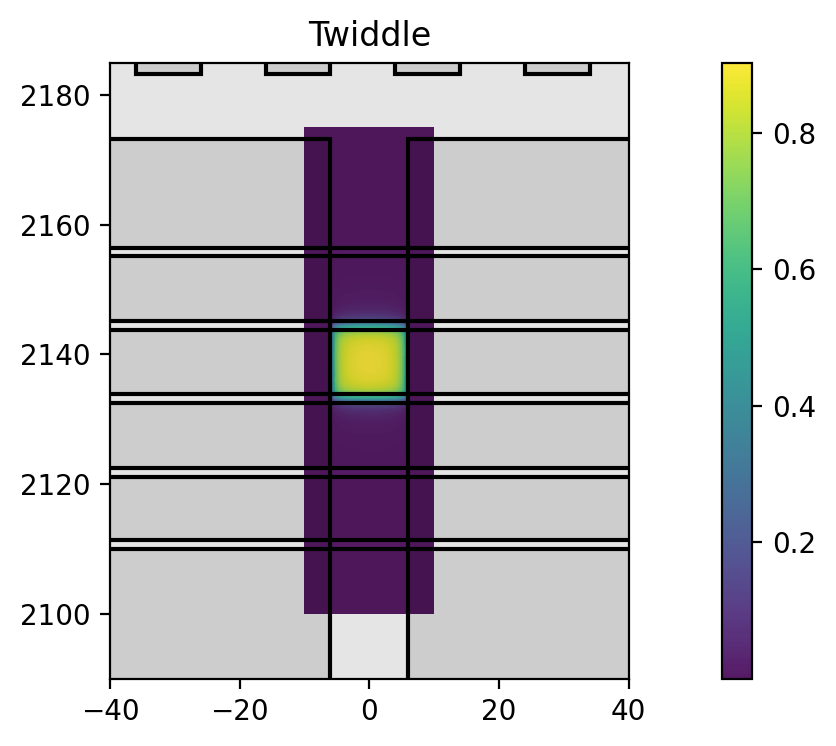

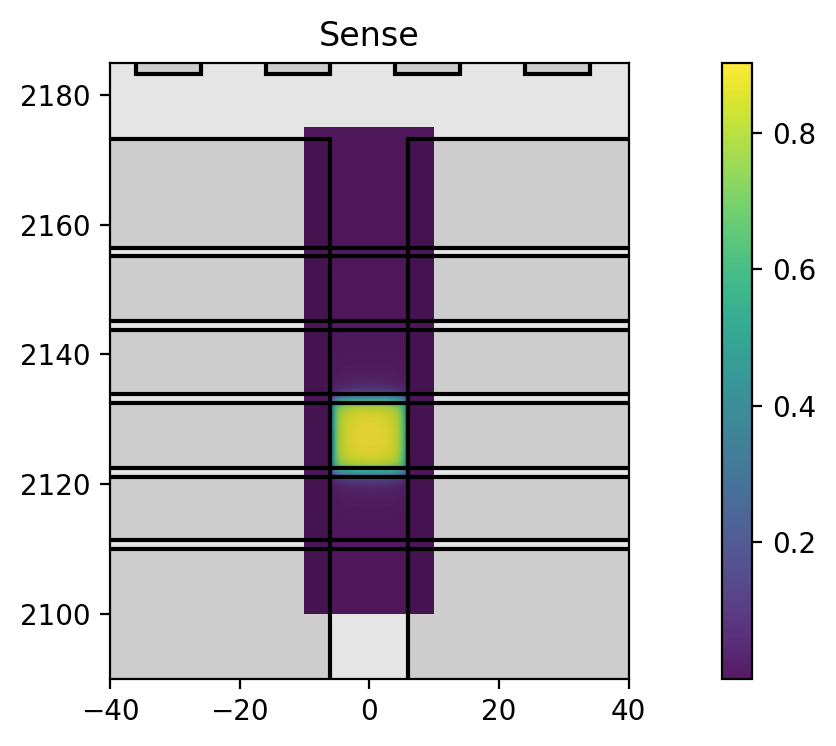

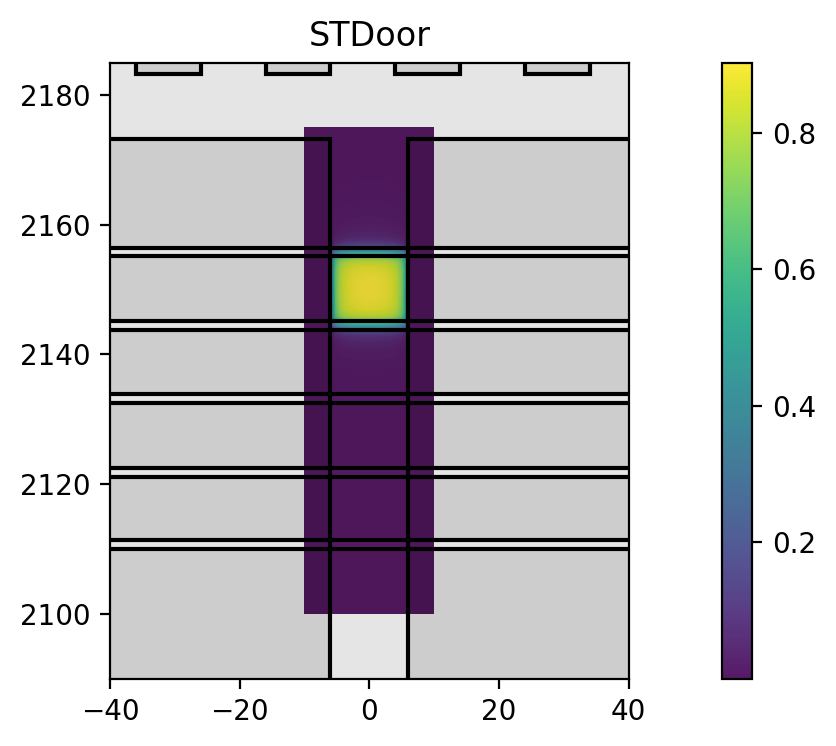

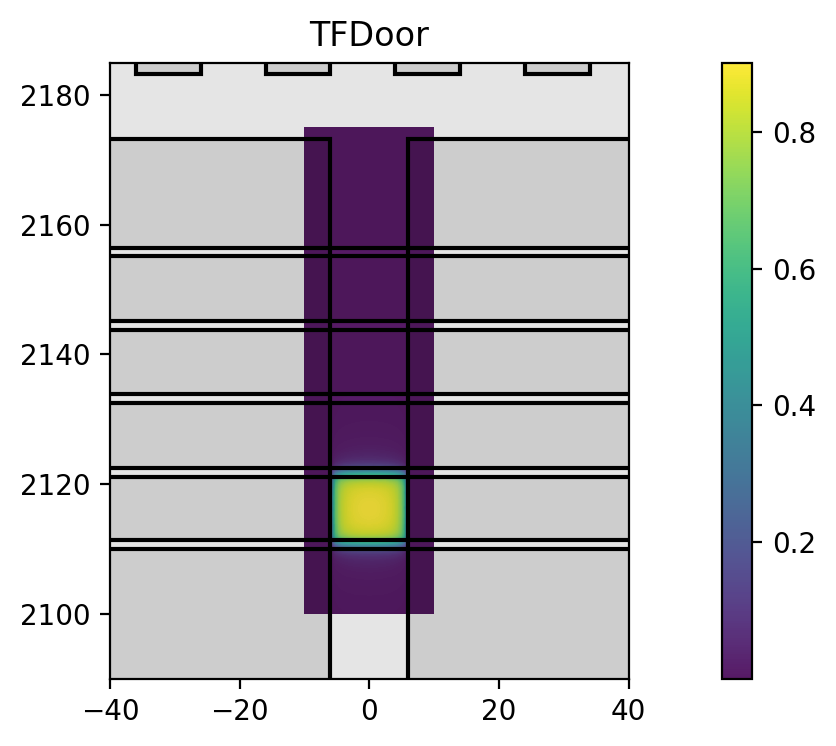

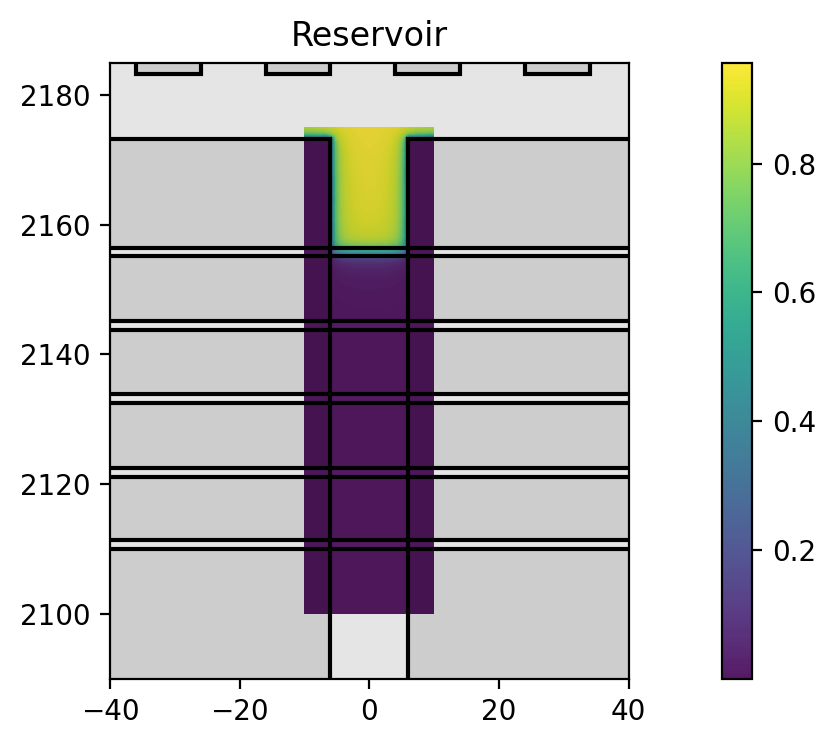

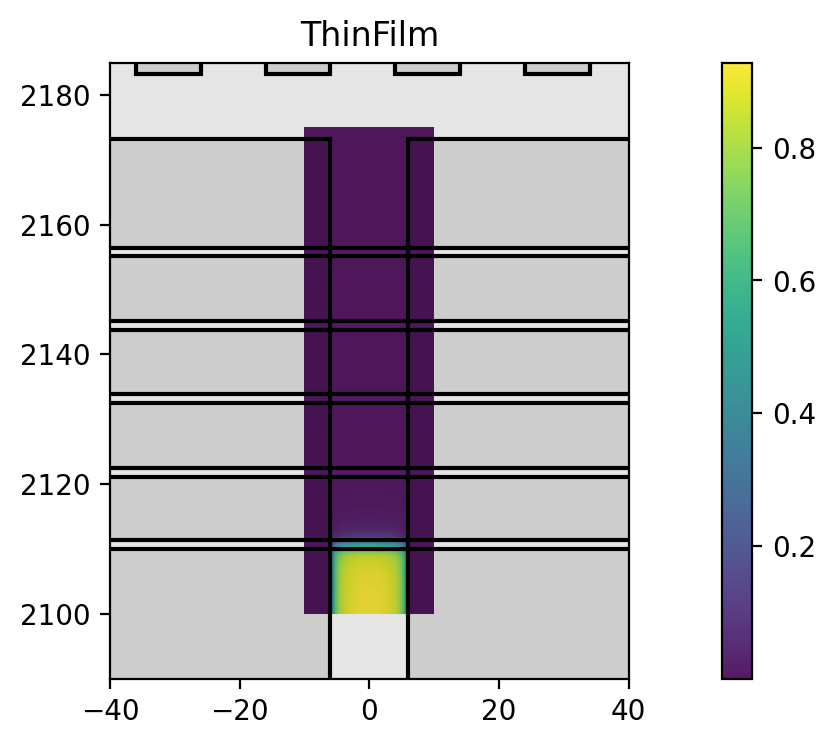

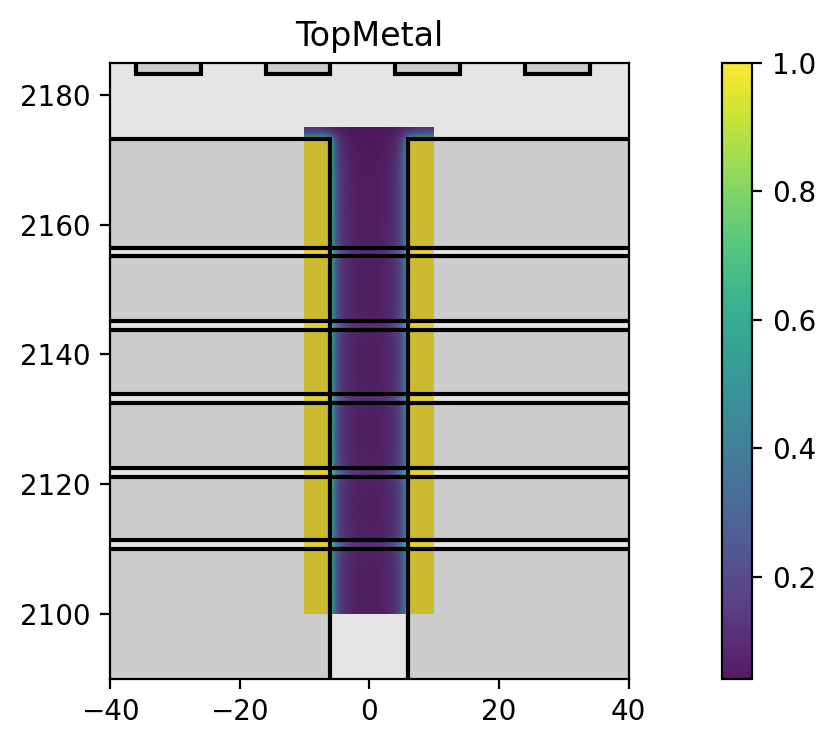

In [65]:
# By setting the voltage of each gate to 1, we can plot the coupling constants
voltages = {
    'Twiddle':0,
    'Sense':0,
    'STDoor':0,
    'TFDoor':0,
    'Reservoir':0,
    'ThinFilm':0,
    'TopMetal':0,
}
for k,v in voltages.items():
    voltages[k] = 1
    x,y,z = ph.potential(ph.p0,voltages)

    plot_gates_potential(x,y,z,k)

    voltages[k] = 0

# DC Voltage Config

### Look at a random voltage config

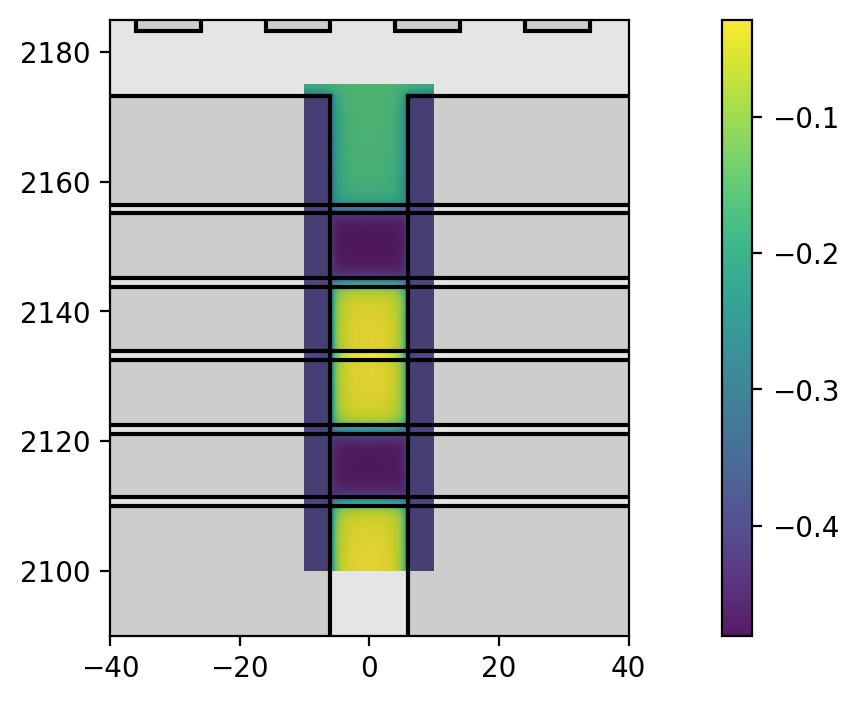

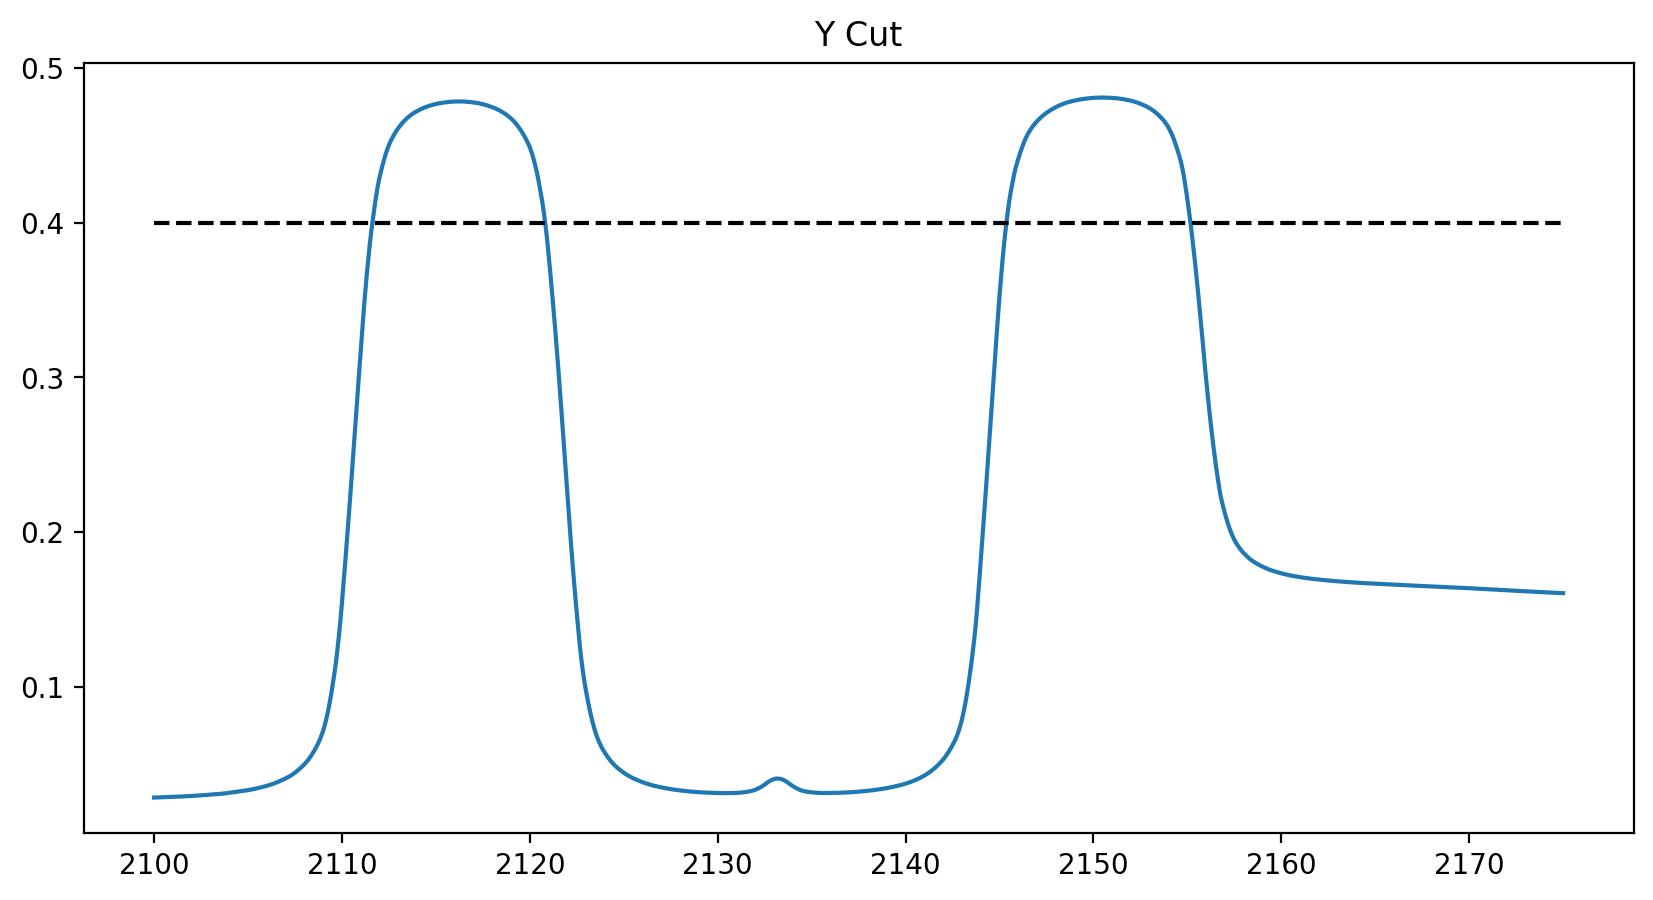

In [66]:
voltages = {
    'Twiddle':0,
    'Sense':0,
    'STDoor':-.5,
    'TFDoor':-.5,
    'Reservoir':-.150,
    'ThinFilm':0,
    'TopMetal':-.4,
}
x,y,z = ph.potential(p,voltages)

plot_gates_potential(x,y,z)

# Take a line cut along the middle and adda dashed line at the top ground plane potential
plt.figure(figsize=(10,5))
plt.title('Y Cut')
plt.plot(y,-z[xCenter,:])
plt.hlines(-voltages['TopMetal'],y[0],y[-1],'k','--')



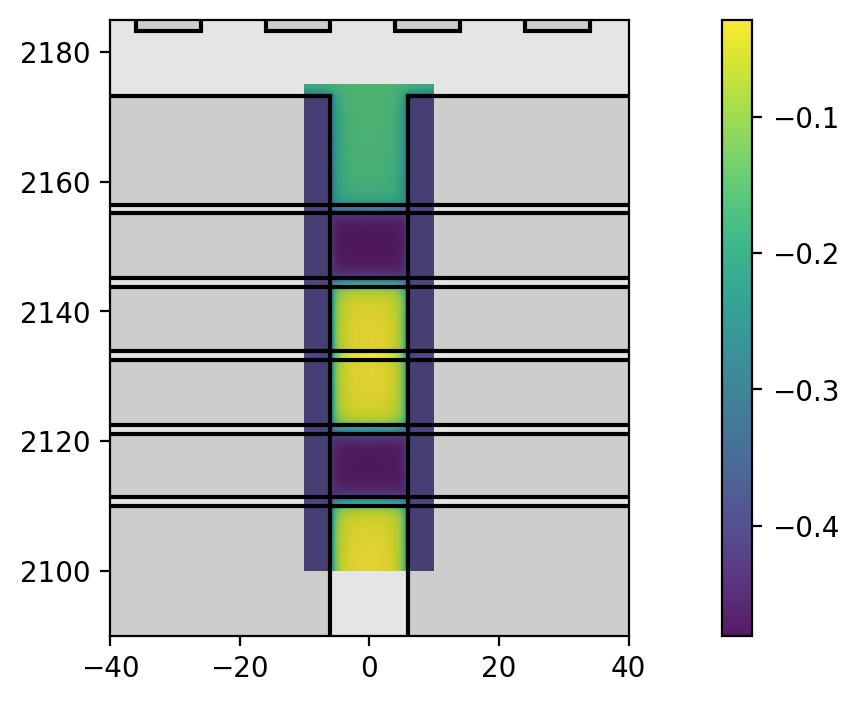

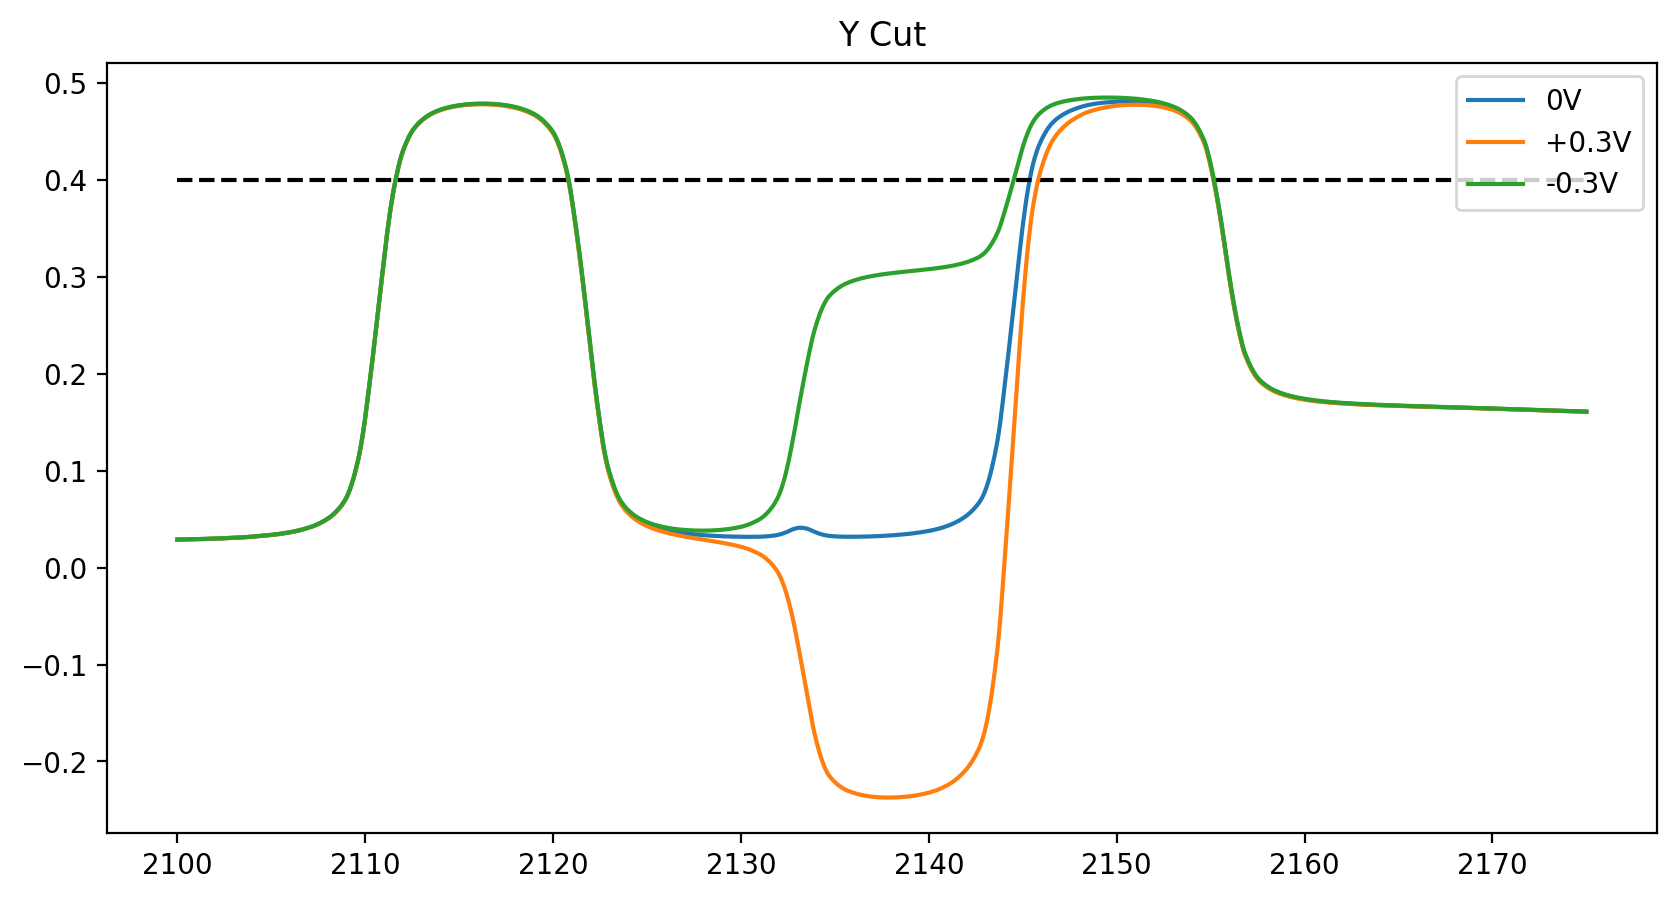

In [67]:
voltages = {
    'Twiddle':0,
    'Sense':0,
    'STDoor':-.5,
    'TFDoor':-.5,
    'Reservoir':-.150,
    'ThinFilm':0,
    'TopMetal':-.4,
}
x,y,z = ph.potential(p,voltages)

plot_gates_potential(x,y,z)


# Plot some line cuts along the center 
plt.figure(figsize=(10,5))
plt.title('Y Cut')
plt.plot(y,-z[xCenter,:],label='0V')
plt.hlines(-voltages['TopMetal'],y[0],y[-1],'k','--')

# Add a line, but with the twiddle at +0.3
voltages['Twiddle'] = .3
x,y,z = ph.potential(p,voltages)
plt.plot(y,-z[xCenter,:],label='+0.3V')

# Add a line, but with the twiddle at -0.3
voltages['Twiddle'] = -.3
x,y,z = ph.potential(p,voltages)
plt.plot(y,-z[xCenter,:],label='-0.3V')

plt.legend()
plt.show()

voltages['Twiddle'] = 0


# Electron Counting

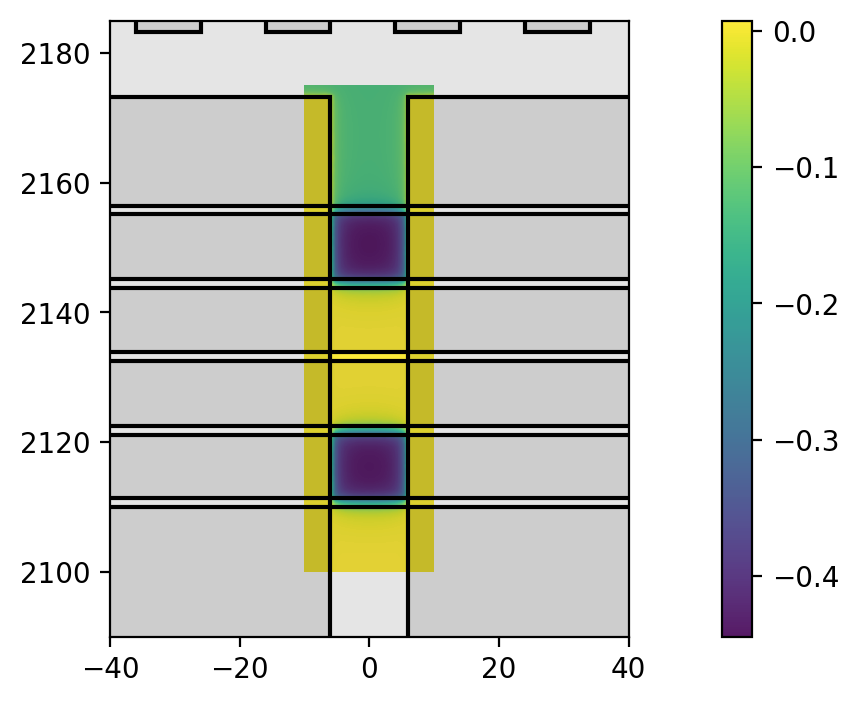

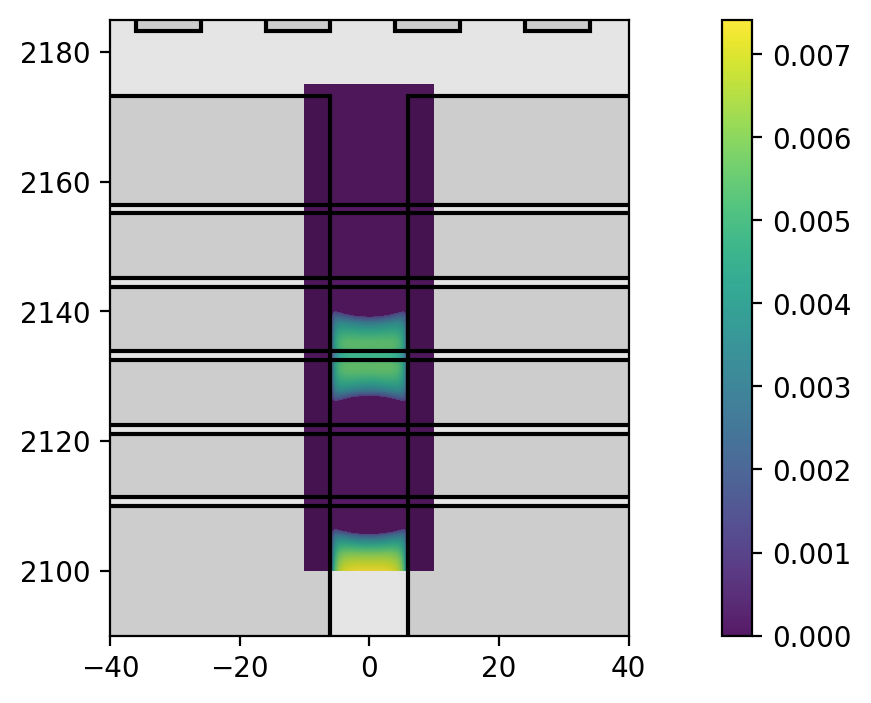

In [87]:
# ePotential sets the electron potential. 0 means the electrons are saturated at the ground plane. -.001 means they are 1 mV below the ground plane.
# yStart and yEnd tell the progrma where to expect the electrons. This makes sure it doesnt try to find solutions in the reservoir or the thin film area.
# epsilon (in um) sets the minimum separation distance for electrons' inital positions. 
#     If too small, the solver may become unstable, but if too large, it may not fit the right amount of electrons in the dot area. It may require some tuning.
# xBuffer and yBuffer (in um) give gome extra space for the solver. 
#     It will crop the potential to the dot area, but for stability reasons, you may want to have some area outside the dot when solving the electron positions.
ePotential= -.001
yStart,yEnd = 2115,2150
epsilon = 0.01
xBuffer,yBuffer=3,3

voltages = {
    'Twiddle':0,
    'Sense':0,
    'STDoor':-.5,
    'TFDoor':-.5,
    'Reservoir':-.150,
    'ThinFilm':0,
    'TopMetal':-.01,
}

# I offset the voltages so that the top metal is zero. This is just useful for the calculations later.
offset = -voltages['TopMetal']
voltages = {k:v+offset for k,v in voltages.items()}


x,y,z = ph.potential(p,voltages)
# 'dot' is just the z potential, but zero when above the electron potential. This can act as a density map for the electrons.
dot = (z>-ePotential)*z



plot_gates_potential(x,y,z)

plot_gates_potential(x,y,dot)

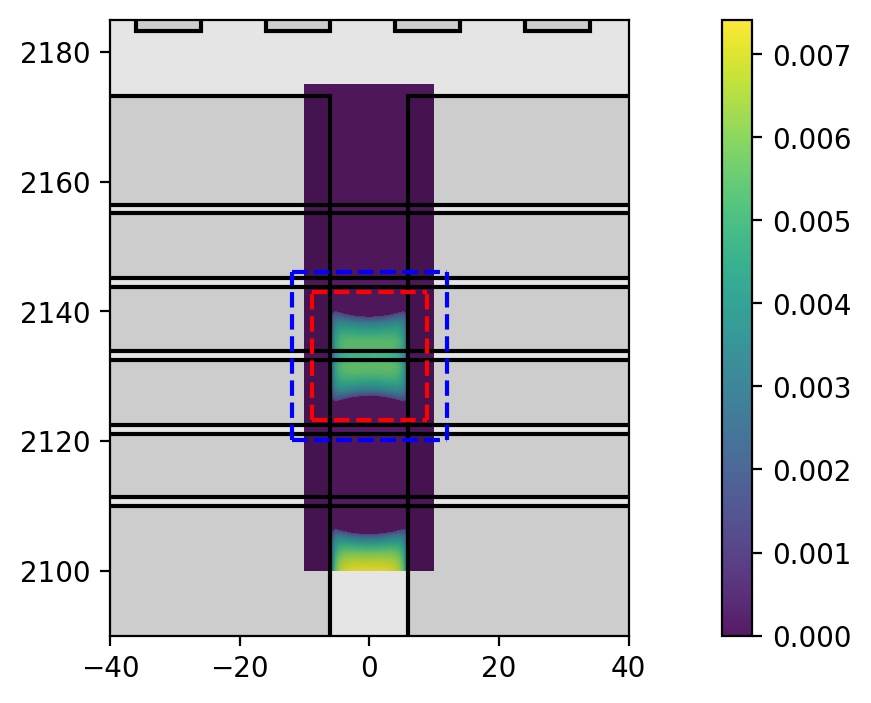

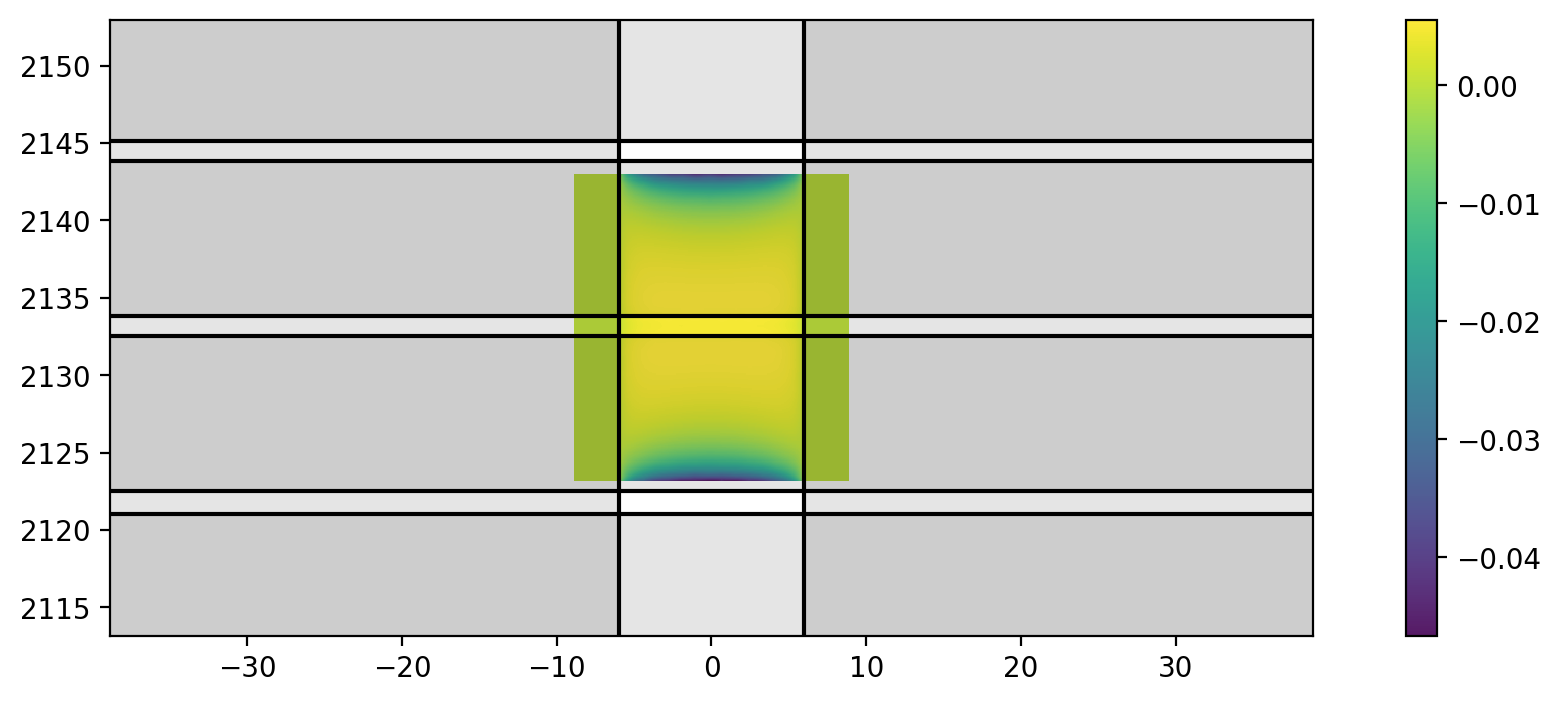

In [88]:
# Calculate the dot area and return a cropped version of p to use for the solver
bounds,dotMin,dotMax = dot_area(p,dot,yStart=yStart,yEnd=yEnd)
plot_gates_potential(x,y,dot)
pCrop = crop_area(p,bounds,xBuffer,yBuffer,showPlot=True)

# get x,y,z and dot for this smaller cropped area
xCrop,yCrop,zCrop = ph.potential(pCrop,voltages)
dotCrop = (zCrop>-ePotential)*zCrop

plot_gates_potential(xCrop,yCrop,zCrop)

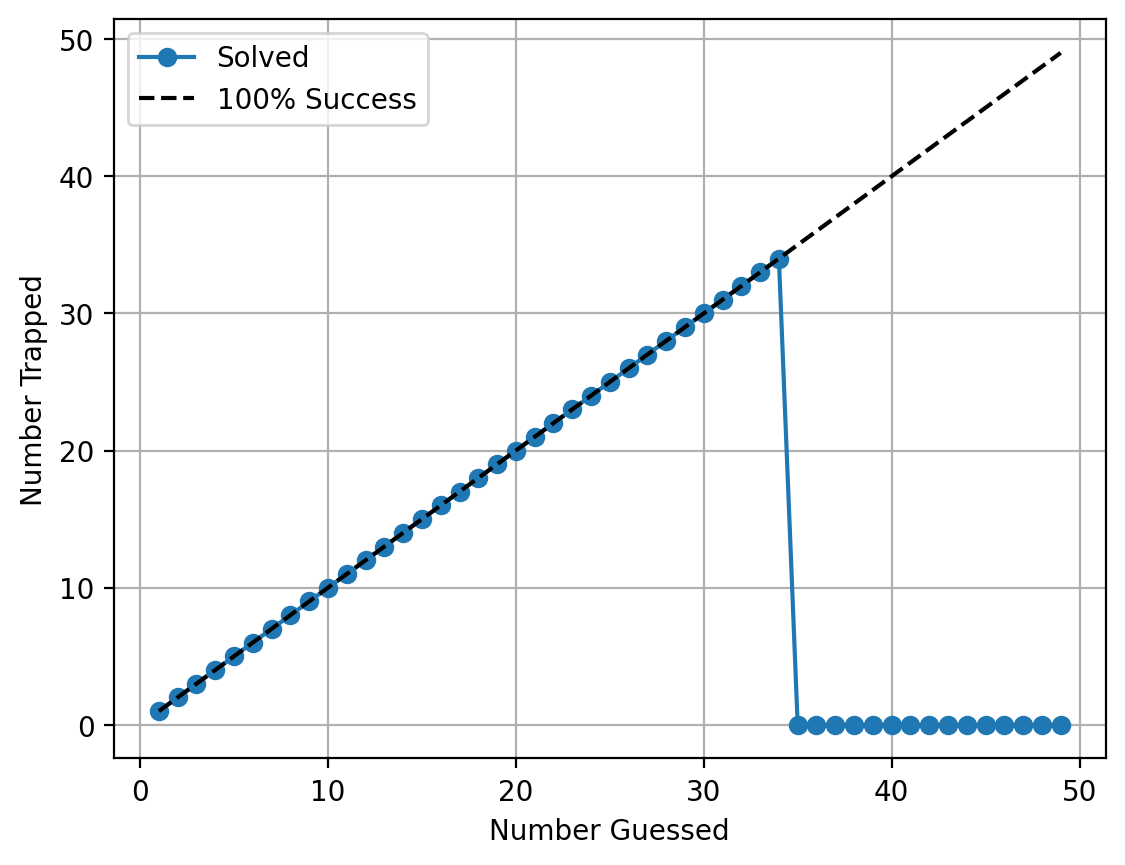

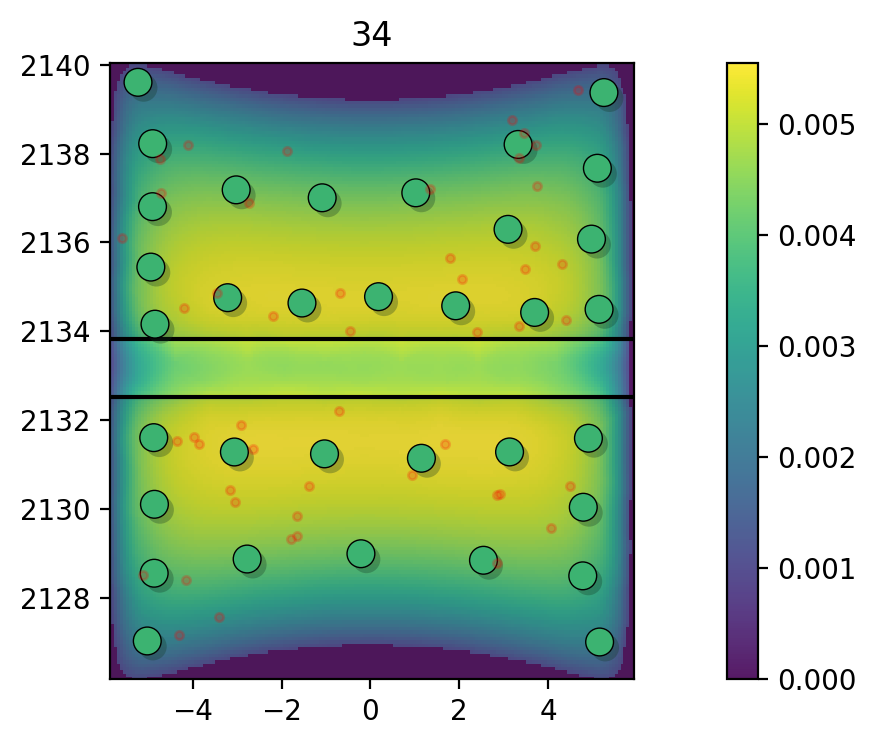

In [231]:
Ns = range(1,50)
maxTries = 20
epsilon = 0.005

# Loop over the number of electrons to try fintting in the dot
counts = []
NMax,resMax = 0,None
for N in Ns:
    # Create the quantum_electron object that will solve for the ground state electron configuration
    f = FullModel(pCrop, voltages, **options)

    # Use the dot and cropped area to guess some inital positions
    points = generate_points(pCrop,dotCrop,N, bounds,dotMin,dotMax,epsilon)
    #convert the points to the format quantum electron wants
    init_condition = convert_shape(points) 
    # Let the quantum electron solver find the minimum energy configuration.
    res = f.get_electron_positions(n_electrons=N, electron_initial_positions=init_condition, verbose=False,suppress_warnings=True)
    Nfound = f.count_electrons_in_dot(res['x'], trap_bounds_x=(bounds[0]*1e-6, bounds[1]*1e-6), trap_bounds_y=(bounds[2]*1e-6, bounds[3]*1e-6))
    # This loop tries the optimizer. If it fails, it will genreate new initial condtions and try again. 
    #      This will continue until the solution converges or it reaches the maximum number of tries.
    tries = 0
    while Nfound != N and tries < maxTries:
        points = generate_points(pCrop,dotCrop,N, bounds,dotMin,dotMax,epsilon)
        init_condition = convert_shape(points)
        res = f.get_electron_positions(n_electrons=N, electron_initial_positions=init_condition, verbose=False,suppress_warnings=True)
        Nfound = f.count_electrons_in_dot(res['x'], trap_bounds_x=(bounds[0]*1e-6, bounds[1]*1e-6), trap_bounds_y=(bounds[2]*1e-6, bounds[3]*1e-6))
        tries+=1

    # Record the number of electrons fit if successful
    if Nfound == N:
        counts.append(N)
        resMax = res
        NMax = N
    else:
        counts.append(0)

# With the voltages I used, it seems like ~ 30-35 electrons can fit in the dot area
plt.plot(Ns,counts,'o-',label='Solved')
plt.plot(Ns,Ns,'k--',label='100% Success')
plt.ylabel('Number Trapped')
plt.xlabel('Number Guessed')
plt.legend()
plt.grid()
plt.show()

plot_gates_potential(xCrop,yCrop,dotCrop)
plt.xlim(bounds[0],bounds[1])
plt.ylim(bounds[2],bounds[3])
f.plot_electron_positions(resMax, ax=plt.gca())
init_x, init_y = r2xy(init_condition)
plt.plot(init_x * 1e6, init_y * 1e6, '.r',alpha=.2)
plt.title(NMax)
plt.show()

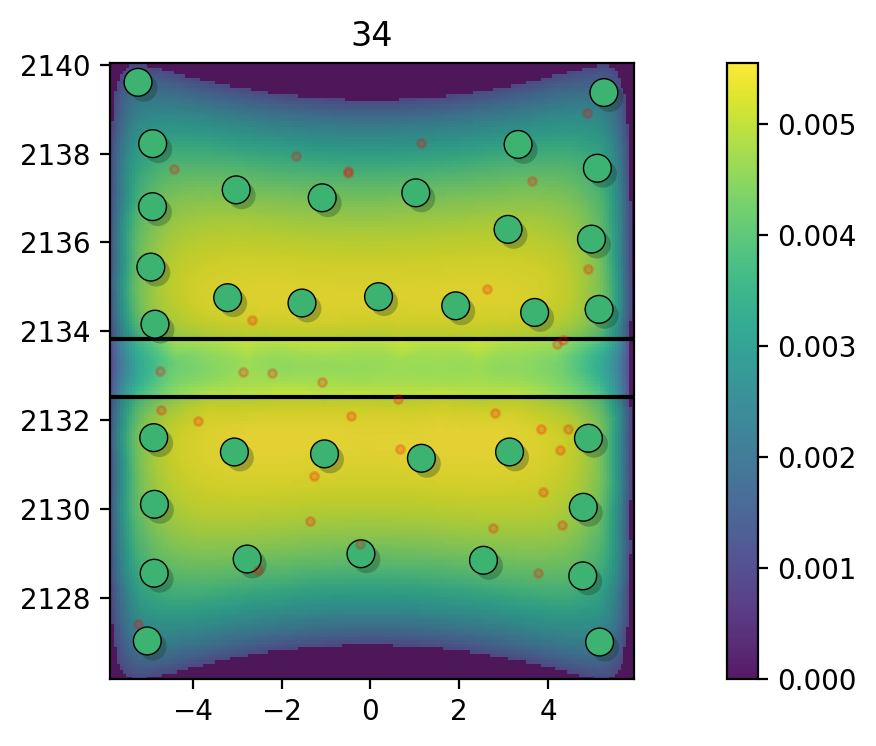

In [235]:
# Another cell to just try a singular N Value, can play with maxTries and epsilon
N = 34
epsilon  = .005
maxTries = 100

f = FullModel(pCrop, voltages, **options)
points = generate_points(pCrop,dotCrop,N, bounds,dotMin,dotMax,epsilon)
init_condition = convert_shape(points) 
res = f.get_electron_positions(n_electrons=N, electron_initial_positions=init_condition, verbose=False,suppress_warnings=True)
Nfound = f.count_electrons_in_dot(res['x'], trap_bounds_x=(bounds[0]*1e-6, bounds[1]*1e-6), trap_bounds_y=(bounds[2]*1e-6, bounds[3]*1e-6))
tries = 0

while Nfound != N and tries < maxTries:
    points = generate_points(pCrop,dotCrop,N, bounds,dotMin,dotMax,epsilon)
    init_condition = convert_shape(points)
    res = f.get_electron_positions(n_electrons=N, electron_initial_positions=init_condition, verbose=False,suppress_warnings=True)
    Nfound = f.count_electrons_in_dot(res['x'], trap_bounds_x=(bounds[0]*1e-6, bounds[1]*1e-6), trap_bounds_y=(bounds[2]*1e-6, bounds[3]*1e-6))
    tries+=1

plot_gates_potential(xCrop,yCrop,dotCrop)
plt.xlim(bounds[0],bounds[1])
plt.ylim(bounds[2],bounds[3])
f.plot_electron_positions(resMax, ax=plt.gca())
init_x, init_y = r2xy(init_condition)
plt.plot(init_x * 1e6, init_y * 1e6, '.r',alpha=.2)
plt.title(NMax)
plt.show()

In [254]:
np.count_nonzero(dotCrop)*(xCrop[1]-xCrop[0])*(yCrop[1]-yCrop[0])

151.01500075470827

In [262]:
#Uses the average voltage of the dot for the voltage in the estimate
vAvg = np.nanmean(np.where(dot == 0, np.nan, dot))
print(f'Average Votlage: {vAvg*1e3:.3f} mV')
print(f'Parallel Plate Density:  {(1.05*8.854e-12)/(625e-9)*(vAvg)/(1.6e-19) *1e-4:.2e} cm^-2')

A = np.count_nonzero(dotCrop)*(xCrop[1]-xCrop[0])*(yCrop[1]-yCrop[0])*1e-12 #Area in m^2 of the dot area (num pixels contained * dx *dy)
print(f'FEM Density:  {NMax/A *1e-4:.2e} cm^-2')

Average Votlage: 4.307 mV
Parallel Plate Density:  4.00e+07 cm^-2
FEM Density:  2.25e+07 cm^-2
